# GANS Model using the Fashion MNIST dataset

Defining our class which has both discriminator and generator model definitions in it, 

In [ ]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/fashion')


# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json

import matplotlib.pyplot as plt
import sys
import numpy as np

### Gan class that holds our fuctions and definition of our discriminator and generator models


In [ ]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        
        
    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)
    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()





Initialize our Gans model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

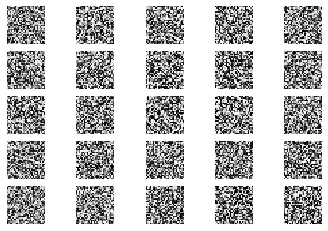

C:\Users\Carlien Sadie\Anaconda3\envs\FoodCNN\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.497751, acc.: 71.88%] [G loss: 0.762963]
2 [D loss: 0.436007, acc.: 73.44%] [G loss: 0.865586]
3 [D loss: 0.354129, acc.: 84.38%] [G loss: 0.937840]
4 [D loss: 0.272257, acc.: 92.19%] [G loss: 1.059907]
5 [D loss: 0.273809, acc.: 93.75%] [G loss: 1.185892]
6 [D loss: 0.207492, acc.: 100.00%] [G loss: 1.232189]
7 [D loss: 0.195563, acc.: 100.00%] [G loss: 1.370798]
8 [D loss: 0.174826, acc.: 100.00%] [G loss: 1.462476]
9 [D loss: 0.175062, acc.: 98.44%] [G loss: 1.558602]
10 [D loss: 0.154693, acc.: 98.44%] [G loss: 1.627643]
11 [D loss: 0.142654, acc.: 98.44%] [G loss: 1.689353]
12 [D loss: 0.115725, acc.: 100.00%] [G loss: 1.769237]
13 [D loss: 0.115619, acc.: 100.00%] [G loss: 1.962603]
14 [D loss: 0.102565, acc.: 100.00%] [G loss: 1.980479]
15 [D loss: 0.102257, acc.: 100.00%] [G loss: 2.070914]
16 [D loss: 0.094156, acc.: 100.00%] [G loss: 2.081512]
17 [D loss: 0.087485, acc.: 100.00%] [G loss: 2.127038]
18 [D loss: 0.092384, acc.: 100.00%] [G loss: 2.231215]
19 [D los

148 [D loss: 0.308413, acc.: 85.94%] [G loss: 3.180173]
149 [D loss: 0.266813, acc.: 85.94%] [G loss: 3.593003]
150 [D loss: 0.322033, acc.: 85.94%] [G loss: 2.862313]
151 [D loss: 0.128046, acc.: 95.31%] [G loss: 3.146254]
152 [D loss: 0.101098, acc.: 98.44%] [G loss: 3.199057]
153 [D loss: 0.304563, acc.: 87.50%] [G loss: 2.753125]
154 [D loss: 0.196771, acc.: 93.75%] [G loss: 3.617201]
155 [D loss: 0.346052, acc.: 92.19%] [G loss: 3.392236]
156 [D loss: 0.101808, acc.: 98.44%] [G loss: 3.409141]
157 [D loss: 0.206920, acc.: 92.19%] [G loss: 3.202903]
158 [D loss: 0.182945, acc.: 93.75%] [G loss: 3.206066]
159 [D loss: 0.354049, acc.: 85.94%] [G loss: 3.285781]
160 [D loss: 0.129467, acc.: 98.44%] [G loss: 3.462070]
161 [D loss: 0.351942, acc.: 84.38%] [G loss: 3.299450]
162 [D loss: 0.184666, acc.: 95.31%] [G loss: 3.174778]
163 [D loss: 0.280087, acc.: 84.38%] [G loss: 3.369909]
164 [D loss: 0.170418, acc.: 95.31%] [G loss: 3.936472]
165 [D loss: 0.395109, acc.: 82.81%] [G loss: 2.

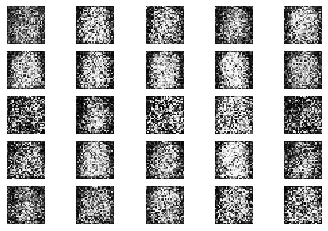

201 [D loss: 0.284897, acc.: 89.06%] [G loss: 3.007039]
202 [D loss: 0.195207, acc.: 92.19%] [G loss: 2.882145]
203 [D loss: 0.482374, acc.: 84.38%] [G loss: 2.605838]
204 [D loss: 0.356402, acc.: 85.94%] [G loss: 3.204070]
205 [D loss: 0.343042, acc.: 85.94%] [G loss: 2.995422]
206 [D loss: 0.262939, acc.: 85.94%] [G loss: 3.614358]
207 [D loss: 0.376257, acc.: 81.25%] [G loss: 3.092227]
208 [D loss: 0.608837, acc.: 75.00%] [G loss: 3.213677]
209 [D loss: 1.000930, acc.: 53.12%] [G loss: 2.325259]
210 [D loss: 0.253512, acc.: 87.50%] [G loss: 2.912757]
211 [D loss: 0.360529, acc.: 82.81%] [G loss: 3.127169]
212 [D loss: 0.368348, acc.: 82.81%] [G loss: 3.653673]
213 [D loss: 0.400402, acc.: 87.50%] [G loss: 2.782007]
214 [D loss: 0.321747, acc.: 84.38%] [G loss: 3.238885]
215 [D loss: 0.347199, acc.: 87.50%] [G loss: 3.120443]
216 [D loss: 0.412986, acc.: 82.81%] [G loss: 2.956015]
217 [D loss: 0.367008, acc.: 82.81%] [G loss: 2.603196]
218 [D loss: 0.600690, acc.: 70.31%] [G loss: 2.

349 [D loss: 0.746181, acc.: 57.81%] [G loss: 0.924746]
350 [D loss: 0.684460, acc.: 59.38%] [G loss: 0.886117]
351 [D loss: 0.690866, acc.: 60.94%] [G loss: 0.941285]
352 [D loss: 0.649310, acc.: 64.06%] [G loss: 0.967035]
353 [D loss: 0.625719, acc.: 71.88%] [G loss: 1.002141]
354 [D loss: 0.751399, acc.: 57.81%] [G loss: 0.972729]
355 [D loss: 0.643580, acc.: 65.62%] [G loss: 1.064525]
356 [D loss: 0.649637, acc.: 64.06%] [G loss: 1.045095]
357 [D loss: 0.708967, acc.: 57.81%] [G loss: 0.995698]
358 [D loss: 0.642609, acc.: 60.94%] [G loss: 1.019745]
359 [D loss: 0.625469, acc.: 70.31%] [G loss: 0.938039]
360 [D loss: 0.673139, acc.: 64.06%] [G loss: 0.923099]
361 [D loss: 0.673014, acc.: 59.38%] [G loss: 0.975643]
362 [D loss: 0.593421, acc.: 73.44%] [G loss: 0.978394]
363 [D loss: 0.725939, acc.: 50.00%] [G loss: 0.857787]
364 [D loss: 0.577965, acc.: 71.88%] [G loss: 0.903626]
365 [D loss: 0.647862, acc.: 64.06%] [G loss: 0.821348]
366 [D loss: 0.686893, acc.: 57.81%] [G loss: 0.

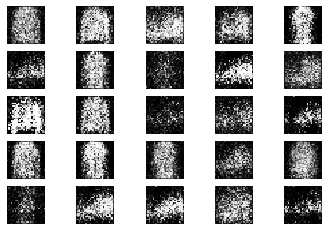

401 [D loss: 0.611079, acc.: 59.38%] [G loss: 0.934390]
402 [D loss: 0.590311, acc.: 68.75%] [G loss: 1.017203]
403 [D loss: 0.692767, acc.: 62.50%] [G loss: 1.101938]
404 [D loss: 0.619965, acc.: 67.19%] [G loss: 1.030538]
405 [D loss: 0.599952, acc.: 76.56%] [G loss: 0.925339]
406 [D loss: 0.602692, acc.: 76.56%] [G loss: 1.069738]
407 [D loss: 0.626741, acc.: 64.06%] [G loss: 1.135947]
408 [D loss: 0.679904, acc.: 64.06%] [G loss: 1.013286]
409 [D loss: 0.628986, acc.: 71.88%] [G loss: 1.052426]
410 [D loss: 0.624377, acc.: 64.06%] [G loss: 0.903412]
411 [D loss: 0.637394, acc.: 68.75%] [G loss: 0.905630]
412 [D loss: 0.619762, acc.: 70.31%] [G loss: 0.998825]
413 [D loss: 0.674446, acc.: 59.38%] [G loss: 0.965549]
414 [D loss: 0.663022, acc.: 62.50%] [G loss: 1.067909]
415 [D loss: 0.630650, acc.: 67.19%] [G loss: 1.075386]
416 [D loss: 0.692203, acc.: 59.38%] [G loss: 0.954202]
417 [D loss: 0.589332, acc.: 71.88%] [G loss: 0.862799]
418 [D loss: 0.636411, acc.: 60.94%] [G loss: 0.

549 [D loss: 0.661336, acc.: 57.81%] [G loss: 0.902715]
550 [D loss: 0.638098, acc.: 64.06%] [G loss: 0.895039]
551 [D loss: 0.603892, acc.: 68.75%] [G loss: 0.903696]
552 [D loss: 0.621430, acc.: 67.19%] [G loss: 0.962879]
553 [D loss: 0.564124, acc.: 68.75%] [G loss: 1.056037]
554 [D loss: 0.582959, acc.: 68.75%] [G loss: 0.919498]
555 [D loss: 0.549950, acc.: 68.75%] [G loss: 0.977354]
556 [D loss: 0.556252, acc.: 73.44%] [G loss: 0.957838]
557 [D loss: 0.566069, acc.: 68.75%] [G loss: 0.944670]
558 [D loss: 0.644587, acc.: 57.81%] [G loss: 0.922131]
559 [D loss: 0.556768, acc.: 70.31%] [G loss: 0.982734]
560 [D loss: 0.595422, acc.: 70.31%] [G loss: 0.961816]
561 [D loss: 0.531140, acc.: 78.12%] [G loss: 0.937616]
562 [D loss: 0.585137, acc.: 68.75%] [G loss: 0.962983]
563 [D loss: 0.618640, acc.: 62.50%] [G loss: 0.902913]
564 [D loss: 0.543848, acc.: 71.88%] [G loss: 0.993663]
565 [D loss: 0.644326, acc.: 68.75%] [G loss: 0.888226]
566 [D loss: 0.550840, acc.: 76.56%] [G loss: 0.

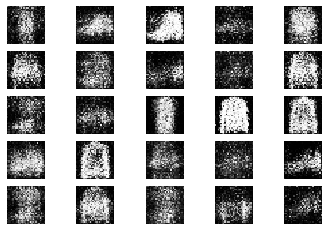

601 [D loss: 0.659223, acc.: 60.94%] [G loss: 0.879856]
602 [D loss: 0.604477, acc.: 65.62%] [G loss: 0.883775]
603 [D loss: 0.578377, acc.: 70.31%] [G loss: 0.948582]
604 [D loss: 0.638583, acc.: 60.94%] [G loss: 0.916103]
605 [D loss: 0.758803, acc.: 56.25%] [G loss: 1.026090]
606 [D loss: 0.668962, acc.: 60.94%] [G loss: 0.977507]
607 [D loss: 0.753716, acc.: 59.38%] [G loss: 0.891086]
608 [D loss: 0.760011, acc.: 53.12%] [G loss: 0.768065]
609 [D loss: 0.630525, acc.: 64.06%] [G loss: 0.843760]
610 [D loss: 0.642545, acc.: 68.75%] [G loss: 0.914867]
611 [D loss: 0.559243, acc.: 75.00%] [G loss: 0.964043]
612 [D loss: 0.644988, acc.: 65.62%] [G loss: 0.948655]
613 [D loss: 0.614612, acc.: 59.38%] [G loss: 1.095284]
614 [D loss: 0.689153, acc.: 51.56%] [G loss: 1.031813]
615 [D loss: 0.718302, acc.: 56.25%] [G loss: 0.969601]
616 [D loss: 0.617413, acc.: 68.75%] [G loss: 0.870558]
617 [D loss: 0.685704, acc.: 54.69%] [G loss: 0.862510]
618 [D loss: 0.670004, acc.: 64.06%] [G loss: 0.

749 [D loss: 0.612249, acc.: 65.62%] [G loss: 0.914511]
750 [D loss: 0.611682, acc.: 68.75%] [G loss: 0.858610]
751 [D loss: 0.679882, acc.: 60.94%] [G loss: 0.947056]
752 [D loss: 0.629094, acc.: 67.19%] [G loss: 0.862184]
753 [D loss: 0.641095, acc.: 64.06%] [G loss: 0.886017]
754 [D loss: 0.637710, acc.: 68.75%] [G loss: 0.906027]
755 [D loss: 0.736157, acc.: 51.56%] [G loss: 0.815873]
756 [D loss: 0.649250, acc.: 67.19%] [G loss: 0.829734]
757 [D loss: 0.641659, acc.: 62.50%] [G loss: 0.831391]
758 [D loss: 0.627652, acc.: 65.62%] [G loss: 0.937825]
759 [D loss: 0.623572, acc.: 71.88%] [G loss: 0.917557]
760 [D loss: 0.686186, acc.: 57.81%] [G loss: 0.869608]
761 [D loss: 0.624283, acc.: 68.75%] [G loss: 0.899709]
762 [D loss: 0.584213, acc.: 71.88%] [G loss: 0.902202]
763 [D loss: 0.694041, acc.: 51.56%] [G loss: 0.885931]
764 [D loss: 0.627107, acc.: 64.06%] [G loss: 0.806306]
765 [D loss: 0.715704, acc.: 50.00%] [G loss: 0.877392]
766 [D loss: 0.618550, acc.: 68.75%] [G loss: 0.

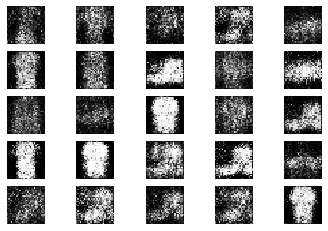

801 [D loss: 0.637726, acc.: 67.19%] [G loss: 0.794103]
802 [D loss: 0.663005, acc.: 53.12%] [G loss: 0.863066]
803 [D loss: 0.581894, acc.: 75.00%] [G loss: 0.782258]
804 [D loss: 0.634555, acc.: 65.62%] [G loss: 0.840833]
805 [D loss: 0.650218, acc.: 62.50%] [G loss: 0.884017]
806 [D loss: 0.620739, acc.: 70.31%] [G loss: 0.902364]
807 [D loss: 0.681916, acc.: 60.94%] [G loss: 0.883239]
808 [D loss: 0.629441, acc.: 65.62%] [G loss: 0.885698]
809 [D loss: 0.626175, acc.: 64.06%] [G loss: 0.879703]
810 [D loss: 0.601541, acc.: 71.88%] [G loss: 0.838279]
811 [D loss: 0.634677, acc.: 62.50%] [G loss: 0.806470]
812 [D loss: 0.629410, acc.: 53.12%] [G loss: 0.800137]
813 [D loss: 0.644501, acc.: 60.94%] [G loss: 0.887511]
814 [D loss: 0.684293, acc.: 54.69%] [G loss: 0.951434]
815 [D loss: 0.686291, acc.: 57.81%] [G loss: 0.835238]
816 [D loss: 0.587798, acc.: 71.88%] [G loss: 0.909624]
817 [D loss: 0.595067, acc.: 70.31%] [G loss: 0.871771]
818 [D loss: 0.635350, acc.: 70.31%] [G loss: 0.

948 [D loss: 0.632227, acc.: 65.62%] [G loss: 0.920830]
949 [D loss: 0.603279, acc.: 70.31%] [G loss: 0.879865]
950 [D loss: 0.686832, acc.: 64.06%] [G loss: 0.912413]
951 [D loss: 0.691674, acc.: 56.25%] [G loss: 0.921106]
952 [D loss: 0.662703, acc.: 56.25%] [G loss: 0.863417]
953 [D loss: 0.685744, acc.: 56.25%] [G loss: 0.814485]
954 [D loss: 0.636280, acc.: 67.19%] [G loss: 0.809322]
955 [D loss: 0.557080, acc.: 76.56%] [G loss: 0.842860]
956 [D loss: 0.627264, acc.: 62.50%] [G loss: 0.878783]
957 [D loss: 0.657128, acc.: 60.94%] [G loss: 0.825204]
958 [D loss: 0.634690, acc.: 60.94%] [G loss: 0.785182]
959 [D loss: 0.637619, acc.: 64.06%] [G loss: 0.901339]
960 [D loss: 0.641307, acc.: 60.94%] [G loss: 0.847946]
961 [D loss: 0.636220, acc.: 60.94%] [G loss: 0.812661]
962 [D loss: 0.628714, acc.: 62.50%] [G loss: 0.835429]
963 [D loss: 0.624054, acc.: 68.75%] [G loss: 0.841008]
964 [D loss: 0.646876, acc.: 54.69%] [G loss: 0.846796]
965 [D loss: 0.642769, acc.: 59.38%] [G loss: 0.

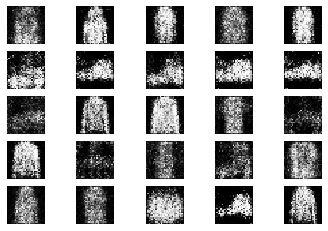

1001 [D loss: 0.604361, acc.: 67.19%] [G loss: 0.808659]
1002 [D loss: 0.638619, acc.: 62.50%] [G loss: 0.842530]
1003 [D loss: 0.634628, acc.: 59.38%] [G loss: 0.833333]
1004 [D loss: 0.630533, acc.: 62.50%] [G loss: 0.926599]
1005 [D loss: 0.626630, acc.: 70.31%] [G loss: 0.893058]
1006 [D loss: 0.646820, acc.: 57.81%] [G loss: 0.840884]
1007 [D loss: 0.632099, acc.: 62.50%] [G loss: 0.772793]
1008 [D loss: 0.637609, acc.: 64.06%] [G loss: 0.843881]
1009 [D loss: 0.639189, acc.: 56.25%] [G loss: 0.829962]
1010 [D loss: 0.657699, acc.: 60.94%] [G loss: 0.832554]
1011 [D loss: 0.596747, acc.: 67.19%] [G loss: 0.854646]
1012 [D loss: 0.616408, acc.: 65.62%] [G loss: 0.845714]
1013 [D loss: 0.668861, acc.: 57.81%] [G loss: 0.862397]
1014 [D loss: 0.632164, acc.: 62.50%] [G loss: 0.826364]
1015 [D loss: 0.590067, acc.: 73.44%] [G loss: 0.849774]
1016 [D loss: 0.594274, acc.: 73.44%] [G loss: 0.856478]
1017 [D loss: 0.631076, acc.: 64.06%] [G loss: 0.863293]
1018 [D loss: 0.656404, acc.: 5

1146 [D loss: 0.684310, acc.: 64.06%] [G loss: 0.823698]
1147 [D loss: 0.601327, acc.: 70.31%] [G loss: 0.885024]
1148 [D loss: 0.638173, acc.: 62.50%] [G loss: 0.793329]
1149 [D loss: 0.606265, acc.: 64.06%] [G loss: 0.882082]
1150 [D loss: 0.634115, acc.: 64.06%] [G loss: 0.843123]
1151 [D loss: 0.604699, acc.: 76.56%] [G loss: 0.808160]
1152 [D loss: 0.605703, acc.: 70.31%] [G loss: 0.852362]
1153 [D loss: 0.676979, acc.: 57.81%] [G loss: 0.840422]
1154 [D loss: 0.599567, acc.: 70.31%] [G loss: 0.916999]
1155 [D loss: 0.606101, acc.: 70.31%] [G loss: 0.862152]
1156 [D loss: 0.640660, acc.: 59.38%] [G loss: 0.834394]
1157 [D loss: 0.695798, acc.: 56.25%] [G loss: 0.879728]
1158 [D loss: 0.596891, acc.: 68.75%] [G loss: 0.804418]
1159 [D loss: 0.602753, acc.: 71.88%] [G loss: 0.811112]
1160 [D loss: 0.637763, acc.: 60.94%] [G loss: 0.812515]
1161 [D loss: 0.631858, acc.: 64.06%] [G loss: 0.814640]
1162 [D loss: 0.614369, acc.: 71.88%] [G loss: 0.835470]
1163 [D loss: 0.677664, acc.: 5

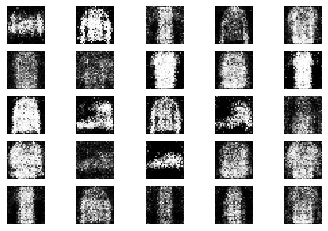

1201 [D loss: 0.625579, acc.: 65.62%] [G loss: 0.855657]
1202 [D loss: 0.651071, acc.: 60.94%] [G loss: 0.900124]
1203 [D loss: 0.577891, acc.: 65.62%] [G loss: 0.863187]
1204 [D loss: 0.654056, acc.: 62.50%] [G loss: 0.909237]
1205 [D loss: 0.621736, acc.: 60.94%] [G loss: 0.886864]
1206 [D loss: 0.678113, acc.: 57.81%] [G loss: 0.843133]
1207 [D loss: 0.606201, acc.: 68.75%] [G loss: 0.908987]
1208 [D loss: 0.613832, acc.: 64.06%] [G loss: 0.903238]
1209 [D loss: 0.662377, acc.: 53.12%] [G loss: 0.925814]
1210 [D loss: 0.651887, acc.: 56.25%] [G loss: 0.836503]
1211 [D loss: 0.609015, acc.: 67.19%] [G loss: 0.855756]
1212 [D loss: 0.740856, acc.: 43.75%] [G loss: 0.826600]
1213 [D loss: 0.637326, acc.: 71.88%] [G loss: 0.870725]
1214 [D loss: 0.672000, acc.: 48.44%] [G loss: 0.872751]
1215 [D loss: 0.655371, acc.: 62.50%] [G loss: 0.797606]
1216 [D loss: 0.614484, acc.: 64.06%] [G loss: 0.860389]
1217 [D loss: 0.651911, acc.: 67.19%] [G loss: 0.845350]
1218 [D loss: 0.600095, acc.: 6

1345 [D loss: 0.694064, acc.: 53.12%] [G loss: 0.868820]
1346 [D loss: 0.705094, acc.: 56.25%] [G loss: 0.857967]
1347 [D loss: 0.621406, acc.: 62.50%] [G loss: 0.896807]
1348 [D loss: 0.649104, acc.: 62.50%] [G loss: 0.888909]
1349 [D loss: 0.645128, acc.: 54.69%] [G loss: 0.833518]
1350 [D loss: 0.638349, acc.: 60.94%] [G loss: 0.824220]
1351 [D loss: 0.640575, acc.: 62.50%] [G loss: 0.865172]
1352 [D loss: 0.628955, acc.: 67.19%] [G loss: 0.812672]
1353 [D loss: 0.627448, acc.: 59.38%] [G loss: 0.864229]
1354 [D loss: 0.640539, acc.: 59.38%] [G loss: 0.835475]
1355 [D loss: 0.606787, acc.: 71.88%] [G loss: 0.829997]
1356 [D loss: 0.642866, acc.: 60.94%] [G loss: 0.818057]
1357 [D loss: 0.641575, acc.: 65.62%] [G loss: 0.854785]
1358 [D loss: 0.651453, acc.: 57.81%] [G loss: 0.902013]
1359 [D loss: 0.633447, acc.: 60.94%] [G loss: 0.871841]
1360 [D loss: 0.632892, acc.: 62.50%] [G loss: 0.867739]
1361 [D loss: 0.631986, acc.: 68.75%] [G loss: 0.877860]
1362 [D loss: 0.649594, acc.: 6

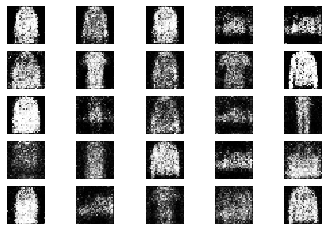

1401 [D loss: 0.630053, acc.: 57.81%] [G loss: 0.834872]
1402 [D loss: 0.650019, acc.: 59.38%] [G loss: 0.770852]
1403 [D loss: 0.659393, acc.: 65.62%] [G loss: 0.822467]
1404 [D loss: 0.579285, acc.: 71.88%] [G loss: 0.858198]
1405 [D loss: 0.640295, acc.: 64.06%] [G loss: 0.923487]
1406 [D loss: 0.598844, acc.: 70.31%] [G loss: 0.862767]
1407 [D loss: 0.636587, acc.: 57.81%] [G loss: 0.869723]
1408 [D loss: 0.636551, acc.: 68.75%] [G loss: 0.939557]
1409 [D loss: 0.638339, acc.: 62.50%] [G loss: 0.897758]
1410 [D loss: 0.627163, acc.: 62.50%] [G loss: 0.817930]
1411 [D loss: 0.622634, acc.: 65.62%] [G loss: 0.900434]
1412 [D loss: 0.659710, acc.: 59.38%] [G loss: 0.847392]
1413 [D loss: 0.591090, acc.: 68.75%] [G loss: 0.911821]
1414 [D loss: 0.624152, acc.: 67.19%] [G loss: 0.891681]
1415 [D loss: 0.574169, acc.: 78.12%] [G loss: 0.880132]
1416 [D loss: 0.649377, acc.: 60.94%] [G loss: 0.823694]
1417 [D loss: 0.702745, acc.: 57.81%] [G loss: 0.826002]
1418 [D loss: 0.601675, acc.: 6

1547 [D loss: 0.681281, acc.: 53.12%] [G loss: 0.844839]
1548 [D loss: 0.648220, acc.: 59.38%] [G loss: 0.824949]
1549 [D loss: 0.642092, acc.: 60.94%] [G loss: 0.847319]
1550 [D loss: 0.637926, acc.: 64.06%] [G loss: 0.827478]
1551 [D loss: 0.668155, acc.: 56.25%] [G loss: 0.904705]
1552 [D loss: 0.614132, acc.: 70.31%] [G loss: 0.903218]
1553 [D loss: 0.642356, acc.: 57.81%] [G loss: 0.951043]
1554 [D loss: 0.615303, acc.: 60.94%] [G loss: 0.850458]
1555 [D loss: 0.595165, acc.: 78.12%] [G loss: 0.968551]
1556 [D loss: 0.567725, acc.: 76.56%] [G loss: 0.907468]
1557 [D loss: 0.570741, acc.: 73.44%] [G loss: 0.952610]
1558 [D loss: 0.659880, acc.: 56.25%] [G loss: 0.902837]
1559 [D loss: 0.644898, acc.: 68.75%] [G loss: 0.847003]
1560 [D loss: 0.619153, acc.: 60.94%] [G loss: 0.886636]
1561 [D loss: 0.595110, acc.: 67.19%] [G loss: 0.949761]
1562 [D loss: 0.652888, acc.: 53.12%] [G loss: 0.911201]
1563 [D loss: 0.732390, acc.: 51.56%] [G loss: 0.858626]
1564 [D loss: 0.591259, acc.: 7

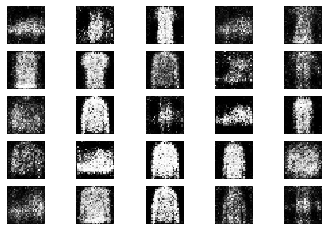

1601 [D loss: 0.685799, acc.: 54.69%] [G loss: 0.909844]
1602 [D loss: 0.618007, acc.: 60.94%] [G loss: 0.882026]
1603 [D loss: 0.598149, acc.: 65.62%] [G loss: 0.867088]
1604 [D loss: 0.645709, acc.: 62.50%] [G loss: 0.865931]
1605 [D loss: 0.549564, acc.: 76.56%] [G loss: 0.816550]
1606 [D loss: 0.589122, acc.: 73.44%] [G loss: 0.835555]
1607 [D loss: 0.593287, acc.: 73.44%] [G loss: 0.910235]
1608 [D loss: 0.662775, acc.: 53.12%] [G loss: 0.921270]
1609 [D loss: 0.592262, acc.: 71.88%] [G loss: 0.867439]
1610 [D loss: 0.623265, acc.: 65.62%] [G loss: 0.814391]
1611 [D loss: 0.634080, acc.: 57.81%] [G loss: 0.917383]
1612 [D loss: 0.612255, acc.: 64.06%] [G loss: 0.885908]
1613 [D loss: 0.633351, acc.: 64.06%] [G loss: 0.929274]
1614 [D loss: 0.632095, acc.: 64.06%] [G loss: 0.869935]
1615 [D loss: 0.627291, acc.: 59.38%] [G loss: 0.804496]
1616 [D loss: 0.660136, acc.: 56.25%] [G loss: 0.948176]
1617 [D loss: 0.595631, acc.: 75.00%] [G loss: 0.995438]
1618 [D loss: 0.716880, acc.: 4

1746 [D loss: 0.581136, acc.: 73.44%] [G loss: 0.909365]
1747 [D loss: 0.639592, acc.: 59.38%] [G loss: 0.927323]
1748 [D loss: 0.655369, acc.: 53.12%] [G loss: 0.875254]
1749 [D loss: 0.658639, acc.: 67.19%] [G loss: 0.938031]
1750 [D loss: 0.663239, acc.: 65.62%] [G loss: 0.978095]
1751 [D loss: 0.682051, acc.: 53.12%] [G loss: 0.894160]
1752 [D loss: 0.599769, acc.: 70.31%] [G loss: 0.930542]
1753 [D loss: 0.651608, acc.: 64.06%] [G loss: 0.865537]
1754 [D loss: 0.600161, acc.: 70.31%] [G loss: 0.873559]
1755 [D loss: 0.666500, acc.: 57.81%] [G loss: 0.892639]
1756 [D loss: 0.576245, acc.: 67.19%] [G loss: 0.841202]
1757 [D loss: 0.690116, acc.: 51.56%] [G loss: 0.921326]
1758 [D loss: 0.630030, acc.: 56.25%] [G loss: 0.855768]
1759 [D loss: 0.626881, acc.: 65.62%] [G loss: 0.886571]
1760 [D loss: 0.615440, acc.: 65.62%] [G loss: 0.925574]
1761 [D loss: 0.600615, acc.: 65.62%] [G loss: 0.875980]
1762 [D loss: 0.657525, acc.: 59.38%] [G loss: 0.911656]
1763 [D loss: 0.671475, acc.: 6

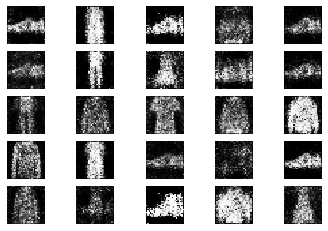

1801 [D loss: 0.611817, acc.: 70.31%] [G loss: 0.932772]
1802 [D loss: 0.623586, acc.: 64.06%] [G loss: 0.957280]
1803 [D loss: 0.674523, acc.: 59.38%] [G loss: 0.998438]
1804 [D loss: 0.622730, acc.: 68.75%] [G loss: 0.885932]
1805 [D loss: 0.551175, acc.: 76.56%] [G loss: 0.913148]
1806 [D loss: 0.603723, acc.: 68.75%] [G loss: 0.896259]
1807 [D loss: 0.608530, acc.: 65.62%] [G loss: 0.980973]
1808 [D loss: 0.560065, acc.: 76.56%] [G loss: 0.959517]
1809 [D loss: 0.614272, acc.: 75.00%] [G loss: 0.893699]
1810 [D loss: 0.597863, acc.: 71.88%] [G loss: 0.851914]
1811 [D loss: 0.593705, acc.: 71.88%] [G loss: 0.915863]
1812 [D loss: 0.552343, acc.: 76.56%] [G loss: 0.885141]
1813 [D loss: 0.601466, acc.: 68.75%] [G loss: 0.896140]
1814 [D loss: 0.650318, acc.: 60.94%] [G loss: 0.926731]
1815 [D loss: 0.627732, acc.: 65.62%] [G loss: 0.949053]
1816 [D loss: 0.705051, acc.: 51.56%] [G loss: 0.913631]
1817 [D loss: 0.613206, acc.: 64.06%] [G loss: 0.931256]
1818 [D loss: 0.617682, acc.: 6

1945 [D loss: 0.653090, acc.: 62.50%] [G loss: 0.844174]
1946 [D loss: 0.657680, acc.: 67.19%] [G loss: 0.831851]
1947 [D loss: 0.594122, acc.: 75.00%] [G loss: 0.947522]
1948 [D loss: 0.611859, acc.: 62.50%] [G loss: 0.877314]
1949 [D loss: 0.560966, acc.: 70.31%] [G loss: 0.888303]
1950 [D loss: 0.643775, acc.: 60.94%] [G loss: 0.871182]
1951 [D loss: 0.678783, acc.: 56.25%] [G loss: 0.868206]
1952 [D loss: 0.562556, acc.: 71.88%] [G loss: 0.810200]
1953 [D loss: 0.603338, acc.: 73.44%] [G loss: 0.949636]
1954 [D loss: 0.579921, acc.: 76.56%] [G loss: 0.945630]
1955 [D loss: 0.582907, acc.: 71.88%] [G loss: 0.950455]
1956 [D loss: 0.599638, acc.: 59.38%] [G loss: 0.970790]
1957 [D loss: 0.675276, acc.: 59.38%] [G loss: 0.931700]
1958 [D loss: 0.630892, acc.: 75.00%] [G loss: 0.920910]
1959 [D loss: 0.672070, acc.: 57.81%] [G loss: 0.895598]
1960 [D loss: 0.690455, acc.: 54.69%] [G loss: 0.910866]
1961 [D loss: 0.629699, acc.: 62.50%] [G loss: 0.903091]
1962 [D loss: 0.654007, acc.: 6

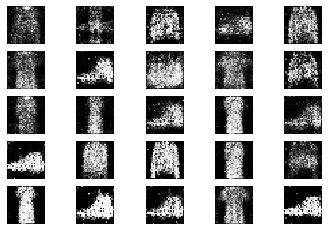

2001 [D loss: 0.644099, acc.: 57.81%] [G loss: 0.888678]
2002 [D loss: 0.596921, acc.: 62.50%] [G loss: 0.929750]
2003 [D loss: 0.572813, acc.: 78.12%] [G loss: 0.836164]
2004 [D loss: 0.605520, acc.: 62.50%] [G loss: 0.890033]
2005 [D loss: 0.723451, acc.: 51.56%] [G loss: 0.780651]
2006 [D loss: 0.628983, acc.: 54.69%] [G loss: 0.872714]
2007 [D loss: 0.626872, acc.: 67.19%] [G loss: 0.908930]
2008 [D loss: 0.605495, acc.: 62.50%] [G loss: 0.871202]
2009 [D loss: 0.612868, acc.: 59.38%] [G loss: 0.894316]
2010 [D loss: 0.616752, acc.: 64.06%] [G loss: 0.902593]
2011 [D loss: 0.596147, acc.: 68.75%] [G loss: 0.882890]
2012 [D loss: 0.640453, acc.: 65.62%] [G loss: 0.858114]
2013 [D loss: 0.548036, acc.: 75.00%] [G loss: 0.861883]
2014 [D loss: 0.632954, acc.: 68.75%] [G loss: 0.952118]
2015 [D loss: 0.584052, acc.: 70.31%] [G loss: 0.939627]
2016 [D loss: 0.642848, acc.: 59.38%] [G loss: 0.789312]
2017 [D loss: 0.618776, acc.: 64.06%] [G loss: 0.908654]
2018 [D loss: 0.646302, acc.: 6

2147 [D loss: 0.650151, acc.: 65.62%] [G loss: 0.955375]
2148 [D loss: 0.625470, acc.: 70.31%] [G loss: 0.845055]
2149 [D loss: 0.603755, acc.: 67.19%] [G loss: 0.882485]
2150 [D loss: 0.639619, acc.: 62.50%] [G loss: 0.872405]
2151 [D loss: 0.578178, acc.: 75.00%] [G loss: 0.879989]
2152 [D loss: 0.671803, acc.: 51.56%] [G loss: 0.870695]
2153 [D loss: 0.603946, acc.: 67.19%] [G loss: 0.918753]
2154 [D loss: 0.682876, acc.: 54.69%] [G loss: 0.914736]
2155 [D loss: 0.554048, acc.: 81.25%] [G loss: 0.933514]
2156 [D loss: 0.630211, acc.: 71.88%] [G loss: 0.870260]
2157 [D loss: 0.566314, acc.: 68.75%] [G loss: 0.923457]
2158 [D loss: 0.662712, acc.: 57.81%] [G loss: 0.876728]
2159 [D loss: 0.638861, acc.: 56.25%] [G loss: 0.903240]
2160 [D loss: 0.647136, acc.: 48.44%] [G loss: 0.790334]
2161 [D loss: 0.606555, acc.: 65.62%] [G loss: 0.849846]
2162 [D loss: 0.653672, acc.: 64.06%] [G loss: 0.958299]
2163 [D loss: 0.617283, acc.: 62.50%] [G loss: 0.992648]
2164 [D loss: 0.591143, acc.: 6

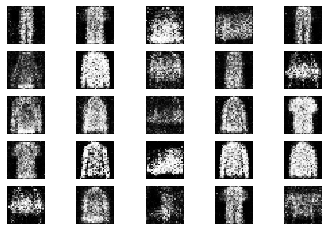

2201 [D loss: 0.630595, acc.: 60.94%] [G loss: 0.989419]
2202 [D loss: 0.642568, acc.: 67.19%] [G loss: 0.938297]
2203 [D loss: 0.563109, acc.: 73.44%] [G loss: 0.860700]
2204 [D loss: 0.638450, acc.: 59.38%] [G loss: 0.905018]
2205 [D loss: 0.543430, acc.: 75.00%] [G loss: 0.861453]
2206 [D loss: 0.609728, acc.: 64.06%] [G loss: 0.895484]
2207 [D loss: 0.552016, acc.: 71.88%] [G loss: 0.894945]
2208 [D loss: 0.593024, acc.: 70.31%] [G loss: 0.937865]
2209 [D loss: 0.658066, acc.: 60.94%] [G loss: 0.877635]
2210 [D loss: 0.607405, acc.: 64.06%] [G loss: 0.915213]
2211 [D loss: 0.612899, acc.: 76.56%] [G loss: 0.894764]
2212 [D loss: 0.632764, acc.: 56.25%] [G loss: 0.893193]
2213 [D loss: 0.691990, acc.: 57.81%] [G loss: 0.914567]
2214 [D loss: 0.652124, acc.: 60.94%] [G loss: 1.006364]
2215 [D loss: 0.628965, acc.: 71.88%] [G loss: 0.920868]
2216 [D loss: 0.653341, acc.: 62.50%] [G loss: 0.980097]
2217 [D loss: 0.681603, acc.: 56.25%] [G loss: 0.947009]
2218 [D loss: 0.620634, acc.: 6

2346 [D loss: 0.611281, acc.: 67.19%] [G loss: 1.014595]
2347 [D loss: 0.584715, acc.: 76.56%] [G loss: 0.979006]
2348 [D loss: 0.613886, acc.: 64.06%] [G loss: 0.917820]
2349 [D loss: 0.557136, acc.: 78.12%] [G loss: 1.045883]
2350 [D loss: 0.599982, acc.: 73.44%] [G loss: 1.017141]
2351 [D loss: 0.675416, acc.: 59.38%] [G loss: 0.951747]
2352 [D loss: 0.671430, acc.: 57.81%] [G loss: 0.988725]
2353 [D loss: 0.615480, acc.: 64.06%] [G loss: 1.020865]
2354 [D loss: 0.667227, acc.: 56.25%] [G loss: 1.027874]
2355 [D loss: 0.656973, acc.: 60.94%] [G loss: 0.891557]
2356 [D loss: 0.576030, acc.: 73.44%] [G loss: 0.908813]
2357 [D loss: 0.646843, acc.: 65.62%] [G loss: 0.916895]
2358 [D loss: 0.624008, acc.: 68.75%] [G loss: 0.974477]
2359 [D loss: 0.686358, acc.: 56.25%] [G loss: 0.974524]
2360 [D loss: 0.690352, acc.: 57.81%] [G loss: 0.864254]
2361 [D loss: 0.649865, acc.: 70.31%] [G loss: 0.858319]
2362 [D loss: 0.629888, acc.: 62.50%] [G loss: 0.831841]
2363 [D loss: 0.655627, acc.: 5

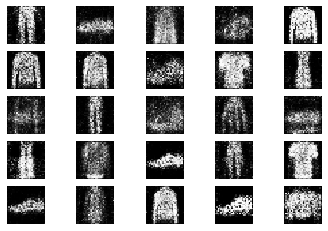

2401 [D loss: 0.560548, acc.: 73.44%] [G loss: 0.854623]
2402 [D loss: 0.659920, acc.: 56.25%] [G loss: 0.910293]
2403 [D loss: 0.604177, acc.: 62.50%] [G loss: 0.950529]
2404 [D loss: 0.638620, acc.: 59.38%] [G loss: 0.910759]
2405 [D loss: 0.703243, acc.: 57.81%] [G loss: 0.860325]
2406 [D loss: 0.629436, acc.: 76.56%] [G loss: 0.908028]
2407 [D loss: 0.589288, acc.: 70.31%] [G loss: 0.968532]
2408 [D loss: 0.543385, acc.: 78.12%] [G loss: 1.010015]
2409 [D loss: 0.596277, acc.: 71.88%] [G loss: 0.971966]
2410 [D loss: 0.655592, acc.: 57.81%] [G loss: 0.936378]
2411 [D loss: 0.673462, acc.: 54.69%] [G loss: 0.897063]
2412 [D loss: 0.610587, acc.: 64.06%] [G loss: 1.005911]
2413 [D loss: 0.659587, acc.: 56.25%] [G loss: 0.920704]
2414 [D loss: 0.648085, acc.: 62.50%] [G loss: 0.905900]
2415 [D loss: 0.587781, acc.: 79.69%] [G loss: 1.048218]
2416 [D loss: 0.604114, acc.: 65.62%] [G loss: 0.956285]
2417 [D loss: 0.633854, acc.: 59.38%] [G loss: 0.969064]
2418 [D loss: 0.572391, acc.: 7

2547 [D loss: 0.636959, acc.: 70.31%] [G loss: 0.963264]
2548 [D loss: 0.650061, acc.: 62.50%] [G loss: 0.855758]
2549 [D loss: 0.661355, acc.: 59.38%] [G loss: 0.782778]
2550 [D loss: 0.613209, acc.: 70.31%] [G loss: 0.911082]
2551 [D loss: 0.640773, acc.: 65.62%] [G loss: 0.821851]
2552 [D loss: 0.666706, acc.: 53.12%] [G loss: 0.889537]
2553 [D loss: 0.614047, acc.: 64.06%] [G loss: 0.879278]
2554 [D loss: 0.659688, acc.: 62.50%] [G loss: 0.931090]
2555 [D loss: 0.683158, acc.: 60.94%] [G loss: 0.901763]
2556 [D loss: 0.644319, acc.: 65.62%] [G loss: 0.959195]
2557 [D loss: 0.698257, acc.: 56.25%] [G loss: 0.941388]
2558 [D loss: 0.607417, acc.: 65.62%] [G loss: 0.893390]
2559 [D loss: 0.627612, acc.: 60.94%] [G loss: 0.882731]
2560 [D loss: 0.650212, acc.: 65.62%] [G loss: 0.926445]
2561 [D loss: 0.647176, acc.: 62.50%] [G loss: 0.961409]
2562 [D loss: 0.585245, acc.: 65.62%] [G loss: 0.957714]
2563 [D loss: 0.654341, acc.: 59.38%] [G loss: 0.892021]
2564 [D loss: 0.715840, acc.: 5

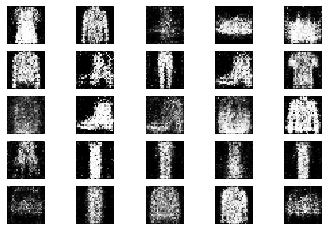

2601 [D loss: 0.602186, acc.: 68.75%] [G loss: 0.934524]
2602 [D loss: 0.605928, acc.: 67.19%] [G loss: 0.931328]
2603 [D loss: 0.633174, acc.: 64.06%] [G loss: 0.890344]
2604 [D loss: 0.595226, acc.: 73.44%] [G loss: 0.879210]
2605 [D loss: 0.660559, acc.: 68.75%] [G loss: 0.902111]
2606 [D loss: 0.602128, acc.: 67.19%] [G loss: 0.894331]
2607 [D loss: 0.626720, acc.: 67.19%] [G loss: 0.911700]
2608 [D loss: 0.565317, acc.: 71.88%] [G loss: 0.789450]
2609 [D loss: 0.697753, acc.: 53.12%] [G loss: 0.851192]
2610 [D loss: 0.607206, acc.: 73.44%] [G loss: 1.031040]
2611 [D loss: 0.592158, acc.: 70.31%] [G loss: 0.966151]
2612 [D loss: 0.708106, acc.: 60.94%] [G loss: 0.910223]
2613 [D loss: 0.555005, acc.: 76.56%] [G loss: 0.898104]
2614 [D loss: 0.620856, acc.: 67.19%] [G loss: 0.921660]
2615 [D loss: 0.587364, acc.: 73.44%] [G loss: 0.869135]
2616 [D loss: 0.652099, acc.: 59.38%] [G loss: 0.889057]
2617 [D loss: 0.624958, acc.: 60.94%] [G loss: 0.960335]
2618 [D loss: 0.610510, acc.: 6

2746 [D loss: 0.739337, acc.: 50.00%] [G loss: 0.942319]
2747 [D loss: 0.629268, acc.: 64.06%] [G loss: 0.928746]
2748 [D loss: 0.599940, acc.: 67.19%] [G loss: 0.904802]
2749 [D loss: 0.678868, acc.: 60.94%] [G loss: 0.883392]
2750 [D loss: 0.628330, acc.: 64.06%] [G loss: 0.912799]
2751 [D loss: 0.619303, acc.: 62.50%] [G loss: 0.959283]
2752 [D loss: 0.665266, acc.: 60.94%] [G loss: 0.821593]
2753 [D loss: 0.554048, acc.: 75.00%] [G loss: 0.945979]
2754 [D loss: 0.680623, acc.: 57.81%] [G loss: 0.926602]
2755 [D loss: 0.547712, acc.: 81.25%] [G loss: 0.947267]
2756 [D loss: 0.664156, acc.: 62.50%] [G loss: 0.912980]
2757 [D loss: 0.589240, acc.: 70.31%] [G loss: 0.808325]
2758 [D loss: 0.577820, acc.: 68.75%] [G loss: 0.910677]
2759 [D loss: 0.646152, acc.: 59.38%] [G loss: 0.800479]
2760 [D loss: 0.604606, acc.: 67.19%] [G loss: 0.828733]
2761 [D loss: 0.609580, acc.: 67.19%] [G loss: 0.990274]
2762 [D loss: 0.585688, acc.: 65.62%] [G loss: 0.954538]
2763 [D loss: 0.686725, acc.: 5

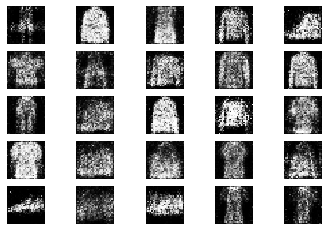

2801 [D loss: 0.593075, acc.: 71.88%] [G loss: 0.946160]
2802 [D loss: 0.642372, acc.: 65.62%] [G loss: 0.996074]
2803 [D loss: 0.629916, acc.: 62.50%] [G loss: 0.969665]
2804 [D loss: 0.667401, acc.: 62.50%] [G loss: 0.859313]
2805 [D loss: 0.646985, acc.: 59.38%] [G loss: 0.889144]
2806 [D loss: 0.695034, acc.: 59.38%] [G loss: 0.901031]
2807 [D loss: 0.621055, acc.: 64.06%] [G loss: 0.811737]
2808 [D loss: 0.590638, acc.: 64.06%] [G loss: 0.928898]
2809 [D loss: 0.648993, acc.: 54.69%] [G loss: 0.980524]
2810 [D loss: 0.557426, acc.: 75.00%] [G loss: 0.995328]
2811 [D loss: 0.663247, acc.: 59.38%] [G loss: 0.970677]
2812 [D loss: 0.654102, acc.: 56.25%] [G loss: 0.920408]
2813 [D loss: 0.620572, acc.: 65.62%] [G loss: 0.877990]
2814 [D loss: 0.657469, acc.: 50.00%] [G loss: 0.964054]
2815 [D loss: 0.582437, acc.: 78.12%] [G loss: 0.989173]
2816 [D loss: 0.679848, acc.: 60.94%] [G loss: 0.956384]
2817 [D loss: 0.610915, acc.: 59.38%] [G loss: 1.017111]
2818 [D loss: 0.634377, acc.: 6

2945 [D loss: 0.688872, acc.: 51.56%] [G loss: 0.978248]
2946 [D loss: 0.642072, acc.: 60.94%] [G loss: 0.936663]
2947 [D loss: 0.655035, acc.: 64.06%] [G loss: 0.844486]
2948 [D loss: 0.641342, acc.: 60.94%] [G loss: 0.995898]
2949 [D loss: 0.612268, acc.: 71.88%] [G loss: 0.939283]
2950 [D loss: 0.646667, acc.: 59.38%] [G loss: 0.915050]
2951 [D loss: 0.667222, acc.: 65.62%] [G loss: 0.991043]
2952 [D loss: 0.614688, acc.: 67.19%] [G loss: 0.987208]
2953 [D loss: 0.602545, acc.: 70.31%] [G loss: 1.021644]
2954 [D loss: 0.690126, acc.: 54.69%] [G loss: 0.959318]
2955 [D loss: 0.590838, acc.: 68.75%] [G loss: 0.912938]
2956 [D loss: 0.629705, acc.: 70.31%] [G loss: 0.875360]
2957 [D loss: 0.634009, acc.: 68.75%] [G loss: 0.847825]
2958 [D loss: 0.660571, acc.: 59.38%] [G loss: 0.877382]
2959 [D loss: 0.674392, acc.: 53.12%] [G loss: 0.886948]
2960 [D loss: 0.582678, acc.: 70.31%] [G loss: 0.936277]
2961 [D loss: 0.619104, acc.: 71.88%] [G loss: 0.926990]
2962 [D loss: 0.655257, acc.: 6

In [32]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=3000, batch_size=32, sample_interval=200)

# Generate random samples from our Gans Model

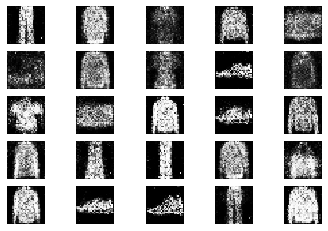

In [34]:
gan.sample_images(epoch =1500)


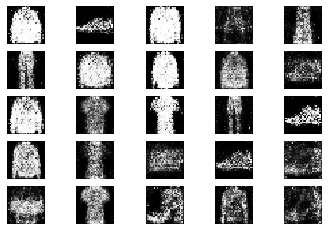

In [35]:
gan.sample_images(epoch =2900)

In [ ]:
Save our models fro future use

In [ ]:
####save model

# serialize model to JSON
model_json = gan.discriminator.to_json()
with open("discriminator.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
gan.discriminator.save_weights("discriminator.h5")
print("Saved model to disk")
 
    

# serialize model to JSON
model_json = gan.generator.to_json()
with open("generator.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
gan.generator.save_weights("generator.h5")
print("Saved generator model to disk")
 

Load our Models

In [ ]:

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model

#Can load this directory into GAns if we disable the self training init method
loaded_model.load_weights("generator.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))